# Análise de Métricas de Qualidade - 75QUA

Este notebook analisa as métricas CK extraídas automaticamente de múltiplas releases de um projeto Java.

## ⚠️ IMPORTANTE: Execute a Análise Primeiro!

**Este notebook requer que você execute a análise automatizada ANTES de usá-lo.**

### Comandos necessários (executar ANTES deste notebook):

```bash
# Análise completa de todas as releases
make analyze REPO=jhy/jsoup

# OU análise limitada (para teste)
make analyze-limit REPO=jhy/jsoup LIMIT=5
```

### O que a análise gera:

A análise automatizada cria os arquivos CSV necessários em `workspace/results/<projeto>/`:
- `<release>/ck/class.csv` - Métricas CK por classe
- `<release>/ck/method.csv` - Métricas CK por método
- `<release>/metadata.json` - Informações da release
- E outros arquivos...

**Se você executar este notebook SEM rodar a análise primeiro, ocorrerão erros!**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import json

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Configuração

Configure o nome do projeto analisado:

In [2]:
# CONFIGURAÇÃO - Altere para o nome do seu projeto
PROJECT_NAME = "jsoup"  # Exemplo: jsoup, gson, okhttp
RESULTS_DIR = Path(f"/workspace/results/{PROJECT_NAME}")

print(f"Analisando projeto: {PROJECT_NAME}")
print(f"Diretório de resultados: {RESULTS_DIR}")
print(f"Diretório existe: {RESULTS_DIR.exists()}")

# Verificação de pré-requisitos
if not RESULTS_DIR.exists():
    print("\n" + "="*80)
    print("⚠️  ERRO: Diretório de resultados não encontrado!")
    print("="*80)
    print("\nVocê precisa executar a análise primeiro:")
    print(f"  make analyze REPO=<owner>/{PROJECT_NAME}")
    print(f"  OU")
    print(f"  make analyze-limit REPO=<owner>/{PROJECT_NAME} LIMIT=5")
    print("\nApós executar a análise, rode este notebook novamente.")
    print("="*80)
else:
    # Verificar se há releases analisadas
    release_dirs = [d for d in RESULTS_DIR.glob('*') if d.is_dir() and not d.name.startswith('.')]
    if len(release_dirs) == 0:
        print("\n" + "="*80)
        print("⚠️  AVISO: Nenhuma release encontrada!")
        print("="*80)
        print("\nExecute a análise primeiro:")
        print(f"  make analyze REPO=<owner>/{PROJECT_NAME}")
        print("="*80)
    else:
        print(f"✓ Encontradas {len(release_dirs)} releases analisadas")
        print("\nTudo pronto! Continue executando as células abaixo.")

Analisando projeto: jsoup
Diretório de resultados: /workspace/results/jsoup
Diretório existe: True
✓ Encontradas 5 releases analisadas

Tudo pronto! Continue executando as células abaixo.


In [3]:
# Consolidar métricas de todas as releases
all_metrics = []

# Listar releases (exclui arquivos, pega apenas diretórios que não começam com '.')
release_dirs = sorted([d for d in RESULTS_DIR.glob('*') if d.is_dir() and not d.name.startswith('.')])

for release_dir in release_dirs:
    class_csv = release_dir / 'ck' / 'class.csv'
    
    if class_csv.exists():
        df = pd.read_csv(class_csv)
        df['release'] = release_dir.name
        
        # Carregar metadata se disponível
        metadata_file = release_dir / 'metadata.json'
        if metadata_file.exists():
            with open(metadata_file) as f:
                metadata = json.load(f)
                df['release_date'] = metadata.get('published_date', '')
        
        all_metrics.append(df)
        print(f"✓ {release_dir.name}: {len(df)} classes")
    else:
        print(f"✗ {release_dir.name}: ck/class.csv não encontrado")

if all_metrics:
    df_all = pd.concat(all_metrics, ignore_index=True)
    print(f"\nTotal de classes analisadas: {len(df_all)}")
    print(f"Total de releases: {df_all['release'].nunique()}")
else:
    print("\n" + "="*80)
    print("⚠️  ERRO: Nenhuma métrica CK encontrada!")
    print("="*80)
    print("\nVerifique se você executou a análise:")
    print(f"  make analyze REPO=<owner>/{PROJECT_NAME}")
    print("\nOu se o nome do projeto está correto na configuração acima.")
    print("="*80)

✓ jsoup-1.12.2: 312 classes
✓ jsoup-1.13.1: 314 classes
✓ jsoup-1.14.1: 324 classes
✓ jsoup-1.14.2: 325 classes
✓ jsoup-1.14.3: 327 classes

Total de classes analisadas: 1602
Total de releases: 5


In [4]:
# Visualizar estrutura dos dados
df_all.head()

,file,class,type,cbo,cboModified,fanin,fanout,wmc,dit,noc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,release,release_date
0,/workspace/projects/jsoup/src/main/java/org/js...,org.jsoup.nodes.Document$QuirksMode,enum,0,0,0,0,0,1,0,...,0,0,0,0,0,4,1,0,jsoup-1.12.2,2020-02-09
1,/workspace/projects/jsoup/src/main/java/org/js...,org.jsoup.helper.DataUtil,class,17,22,5,17,64,1,0,...,29,5,0,1,0,168,17,0,jsoup-1.12.2,2020-02-09
2,/workspace/projects/jsoup/src/main/java/org/js...,org.jsoup.select.StructuralEvaluator$Immediate...,innerclass,3,3,0,3,5,3,0,...,1,1,0,0,0,14,8,0,jsoup-1.12.2,2020-02-09
3,/workspace/projects/jsoup/src/main/java/org/js...,org.jsoup.Connection$Response,interface,4,4,0,4,10,1,0,...,0,0,0,0,0,115,0,0,jsoup-1.12.2,2020-02-09
4,/workspace/projects/jsoup/src/main/java/org/js...,org.jsoup.helper.ChangeNotifyingArrayList,class,2,5,3,2,13,4,0,...,0,0,0,0,0,32,1025,0,jsoup-1.12.2,2020-02-09


## 4. Estatísticas Descritivas por Release

In [5]:
# Agregar métricas por release
metrics_by_release = df_all.groupby('release').agg({
    'wmc': ['mean', 'median', 'std', 'max'],
    'dit': ['mean', 'median', 'std', 'max'],
    'noc': ['mean', 'median', 'std', 'max'],
    'cbo': ['mean', 'median', 'std', 'max'],
    'lcom': ['mean', 'median', 'std', 'max'],
    'rfc': ['mean', 'median', 'std', 'max'],
    'loc': ['sum', 'mean', 'median', 'std']
}).round(2)

metrics_by_release

wmc                      dit                    noc         \
               mean median    std  max  mean median   std max  mean median   
release                                                                      
jsoup-1.12.2  14.82    5.0  27.63  220  1.84    1.0  3.27  54  0.31    0.0   
jsoup-1.13.1  15.13    6.0  28.62  234  1.83    1.0  3.26  54  0.31    0.0   
jsoup-1.14.1  15.41    6.0  29.41  248  1.82    1.0  3.21  54  0.31    0.0   
jsoup-1.14.2  15.57    6.0  29.85  248  1.82    1.0  3.21  54  0.31    0.0   
jsoup-1.14.3  16.06    6.0  31.27  250  1.82    1.0  3.20  54  0.31    0.0   

              ...     lcom           rfc                       loc         \
              ...      std    max   mean median    std  max    sum   mean   
release       ...                                                           
jsoup-1.12.2  ...   755.62   9453  13.29    6.0  21.50  157  24258  77.75   
jsoup-1.13.1  ...   821.77  10731  13.77    6.0  21.99  164  24901  79.30   
jsoup-1.14.1  ...   934.49  11476  14.46    6.0  22.98  175  26468  81.69   
jsoup-1.14.2  ...   967.13  12246  14.59    7.0  23.12  176  26809  82.49   
jsoup-1.14.3  ...  1049.80  14028  15.02    7.0  23.70  179  27822  85.08   

                             
             median     std  
release                      
jsoup-1.12.2   24.5  183.37  
jsoup-1.13.1   26.0  185.76  
jsoup-1.14.1   26.0  192.49  
jsoup-1.14.2   27.0  194.33  
jsoup-1.14.3   27.0  200.67  

[5 rows x 28 columns]

## 5. Visualização da Evolução das Métricas

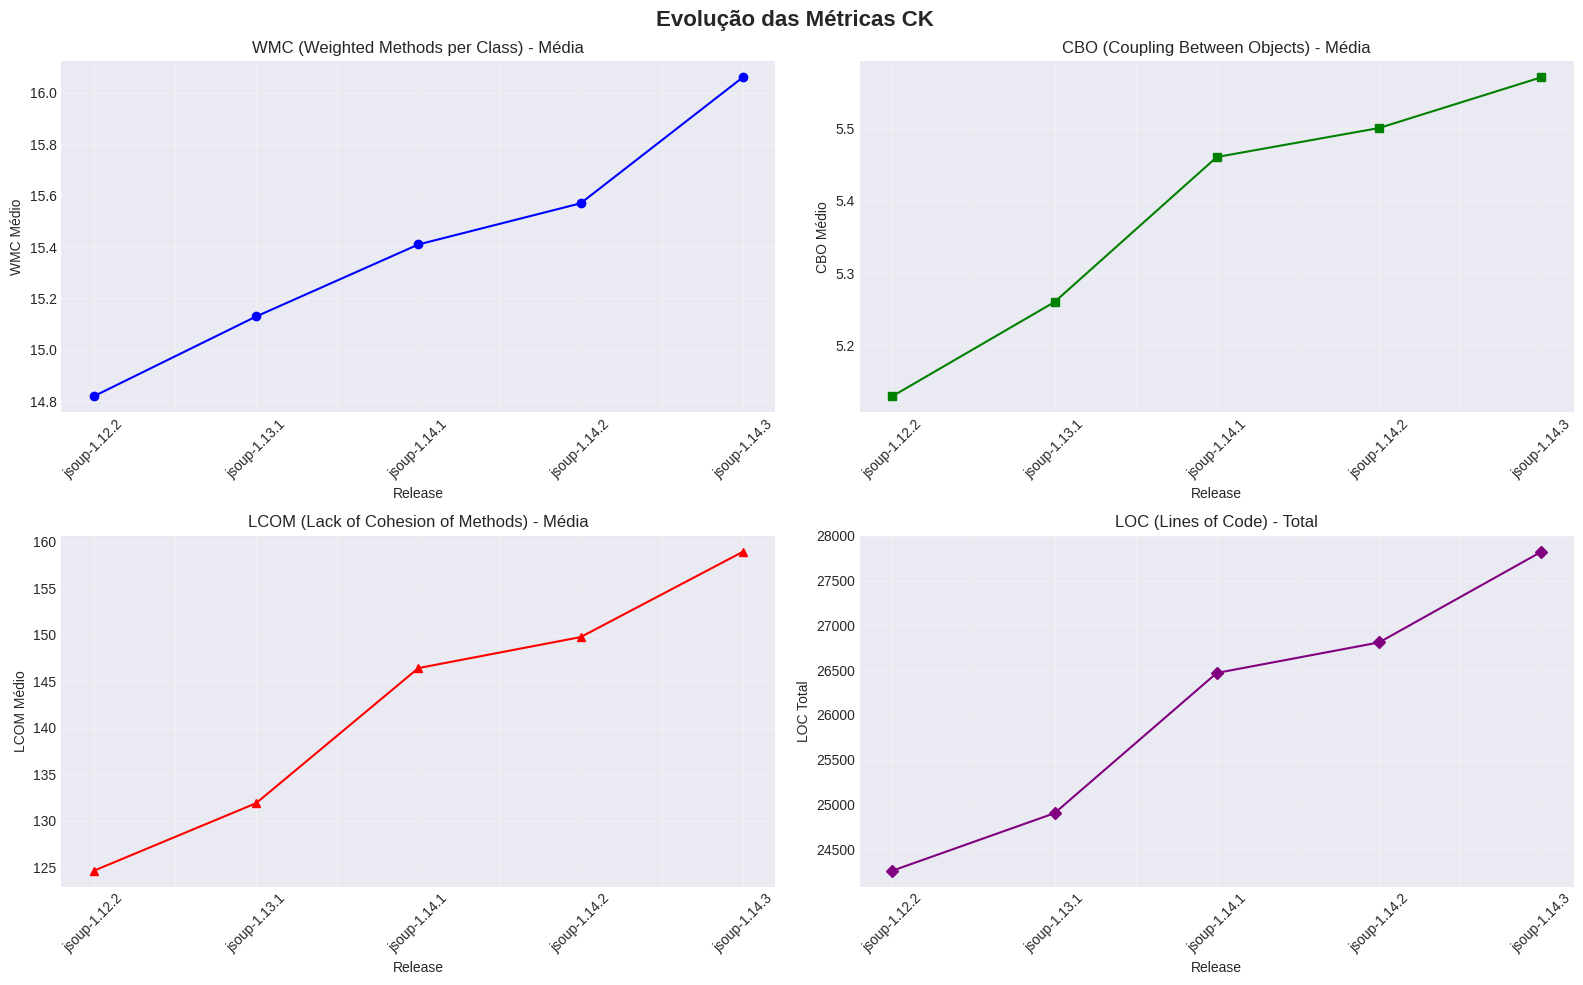

In [6]:
# Gráfico de evolução - WMC (Weighted Methods per Class)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Evolução das Métricas CK', fontsize=16, fontweight='bold')

# WMC
metrics_by_release[('wmc', 'mean')].plot(ax=axes[0, 0], marker='o', color='blue')
axes[0, 0].set_title('WMC (Weighted Methods per Class) - Média')
axes[0, 0].set_xlabel('Release')
axes[0, 0].set_ylabel('WMC Médio')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# CBO
metrics_by_release[('cbo', 'mean')].plot(ax=axes[0, 1], marker='s', color='green')
axes[0, 1].set_title('CBO (Coupling Between Objects) - Média')
axes[0, 1].set_xlabel('Release')
axes[0, 1].set_ylabel('CBO Médio')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# LCOM
metrics_by_release[('lcom', 'mean')].plot(ax=axes[1, 0], marker='^', color='red')
axes[1, 0].set_title('LCOM (Lack of Cohesion of Methods) - Média')
axes[1, 0].set_xlabel('Release')
axes[1, 0].set_ylabel('LCOM Médio')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# LOC
metrics_by_release[('loc', 'sum')].plot(ax=axes[1, 1], marker='D', color='purple')
axes[1, 1].set_title('LOC (Lines of Code) - Total')
axes[1, 1].set_xlabel('Release')
axes[1, 1].set_ylabel('LOC Total')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'metrics_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Distribuição das Métricas

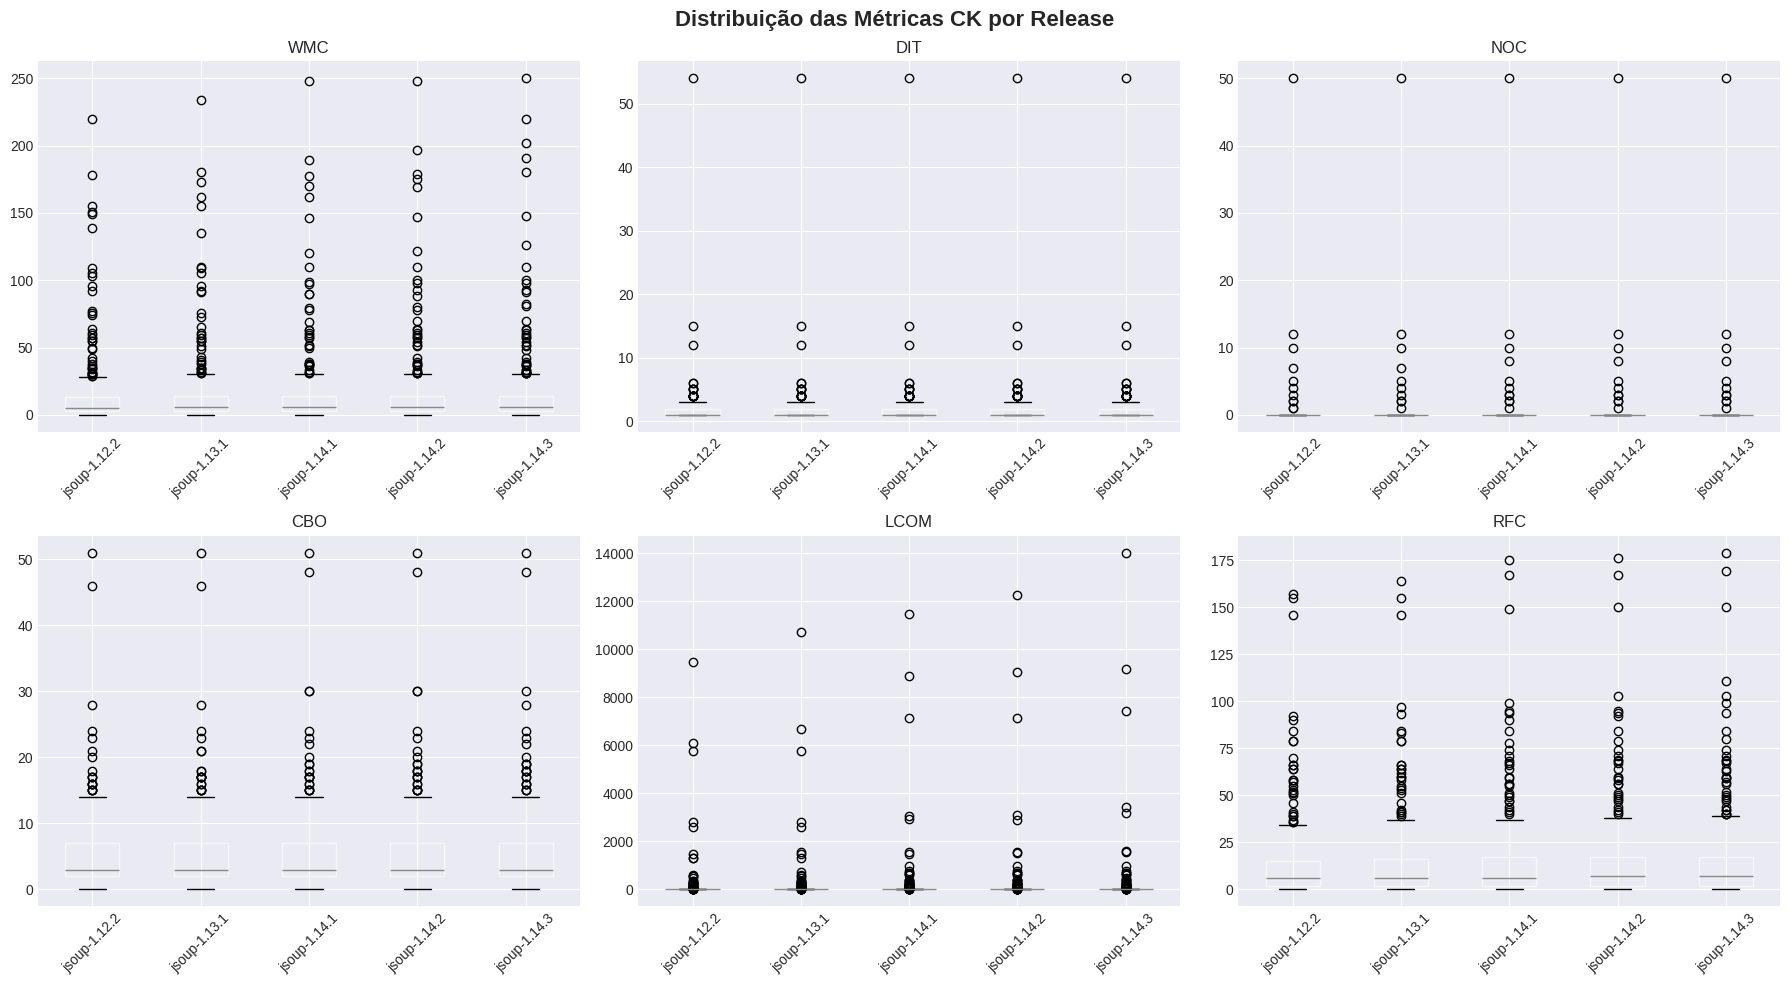

In [7]:
# Boxplots das métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribuição das Métricas CK', fontsize=16, fontweight='bold')

metrics = ['wmc', 'dit', 'noc', 'cbo', 'lcom', 'rfc']
positions = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]

for metric, pos in zip(metrics, positions):
    df_all.boxplot(column=metric, by='release', ax=axes[pos], rot=45)
    axes[pos].set_title(f'{metric.upper()}')
    axes[pos].set_xlabel('')
    
plt.suptitle('Distribuição das Métricas CK por Release', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'metrics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Correlação entre Métricas

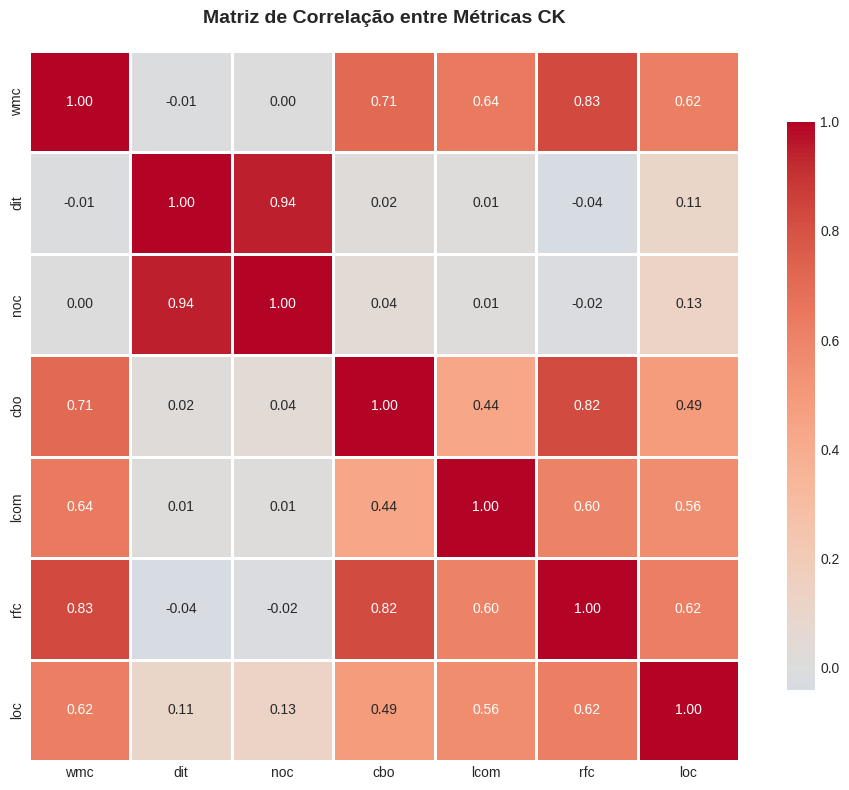

In [8]:
# Matriz de correlação
correlation_metrics = ['wmc', 'dit', 'noc', 'cbo', 'lcom', 'rfc', 'loc']
corr_matrix = df_all[correlation_metrics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Métricas CK', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Top Classes com Problemas de Qualidade

In [9]:
# Classes com maior complexidade (WMC) na última release
latest_release = df_all[df_all['release'] == df_all['release'].unique()[-1]]

print("Top 10 Classes com Maior Complexidade (WMC):")
print(latest_release.nlargest(10, 'wmc')[['class', 'wmc', 'cbo', 'lcom', 'loc']])

print("\nTop 10 Classes com Maior Acoplamento (CBO):")
print(latest_release.nlargest(10, 'cbo')[['class', 'wmc', 'cbo', 'lcom', 'loc']])

print("\nTop 10 Classes com Menor Coesão (LCOM):")
print(latest_release.nlargest(10, 'lcom')[['class', 'wmc', 'cbo', 'lcom', 'loc']])

Top 10 Classes com Maior Complexidade (WMC):
                                                 class  wmc  cbo   lcom   loc
1287                           org.jsoup.nodes.Element  250   48   7412   752
1302                  org.jsoup.parser.HtmlTreeBuilder  220   28   3436   643
1526                  org.jsoup.parser.CharacterReader  202    5      0   500
1359  org.jsoup.parser.HtmlTreeBuilderState$Anonymous7  191   18     10   602
1298                   org.jsoup.parser.HtmlParserTest  180   22  14028  1165
1317                       org.jsoup.nodes.ElementTest  148   19   9174  1461
1377                              org.jsoup.nodes.Node  126   17   1590   375
1476                         org.jsoup.select.Elements  110   17   1540   286
1533          org.jsoup.helper.HttpConnection$Response  100   23     55   354
1544                      org.jsoup.select.QueryParser   98   51      0   265

Top 10 Classes com Maior Acoplamento (CBO):
                                         class  wmc 

## 9. Análise de Tendências

In [10]:
# Calcular taxa de crescimento das métricas
first_release = metrics_by_release.iloc[0]
last_release = metrics_by_release.iloc[-1]

growth_rates = pd.DataFrame({
    'Métrica': ['WMC', 'DIT', 'NOC', 'CBO', 'LCOM', 'RFC', 'LOC (total)'],
    'Primeira Release': [
        first_release[('wmc', 'mean')],
        first_release[('dit', 'mean')],
        first_release[('noc', 'mean')],
        first_release[('cbo', 'mean')],
        first_release[('lcom', 'mean')],
        first_release[('rfc', 'mean')],
        first_release[('loc', 'sum')]
    ],
    'Última Release': [
        last_release[('wmc', 'mean')],
        last_release[('dit', 'mean')],
        last_release[('noc', 'mean')],
        last_release[('cbo', 'mean')],
        last_release[('lcom', 'mean')],
        last_release[('rfc', 'mean')],
        last_release[('loc', 'sum')]
    ]
})

growth_rates['Variação (%)'] = ((growth_rates['Última Release'] - growth_rates['Primeira Release']) / growth_rates['Primeira Release'] * 100).round(2)

print("Análise de Crescimento das Métricas:")
print(growth_rates)

Análise de Crescimento das Métricas:
       Métrica  Primeira Release  Última Release  Variação (%)
0          WMC             14.82           16.06          8.37
1          DIT              1.84            1.82         -1.09
2          NOC              0.31            0.31          0.00
3          CBO              5.13            5.57          8.58
4         LCOM            124.62          158.90         27.51
5          RFC             13.29           15.02         13.02
6  LOC (total)          24258.00        27822.00         14.69


## 10. Exportar Resultados Consolidados

In [11]:
# Salvar métricas agregadas
metrics_by_release.to_csv(RESULTS_DIR / 'metrics_summary_statistical.csv')
print(f"Estatísticas salvas em: {RESULTS_DIR / 'metrics_summary_statistical.csv'}")

# Salvar taxa de crescimento
growth_rates.to_csv(RESULTS_DIR / 'growth_rates.csv', index=False)
print(f"Taxas de crescimento salvas em: {RESULTS_DIR / 'growth_rates.csv'}")

print("\nAnálise completa!")

Estatísticas salvas em: /workspace/results/jsoup/metrics_summary_statistical.csv
Taxas de crescimento salvas em: /workspace/results/jsoup/growth_rates.csv

Análise completa!
